## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020

Andreas Theodoulou and Michael Gaidis

(Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***date_block_num*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#Load Files
Load competition data files and import helpful custom code libraries from shared GitHub repository

In [23]:
# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai/"
repo_name = 'Kag/'
branch_name = 'master/'
base_url = git_hub_url + repo_name + branch_name

# List of the data files (path relative to GitHub branch), to be loaded into pandas DataFrames
data_files = [  "readonly/final_project_data/items.csv",
                "readonly/final_project_data/item_categories.csv",
                "readonly/final_project_data/shops.csv",
                "readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/sales_train.csv.gz",
                "readonly/final_project_data/test.csv.gz"  
              ]

# List of helper code files, to be loaded into Colab and available for python import
code_files = ["kaggle_utils_at_mg.py"]

In [24]:
import pandas as pd
import os

def xfer_github_to_colab(path):
    filename = path.rsplit("/")[-1]
    os.system("wget " + base_url + "{} -O {}".format(path, filename))
    print(base_url + path + " ---> loaded into ---> " + filename)
    return filename

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
    print("Loading Files from GitHub to Colab\n")

    # Loop to load the above data files into appropriately-named pandas DataFrames
    for path_name in data_files:
      filename = xfer_github_to_colab(path_name)
      data_frame_name = path_name.rsplit("/")[-1].split(".")[0]
      exec(data_frame_name + " = pd.read_csv(filename)")
      print("Data Frame: " + data_frame_name)
      print(eval(data_frame_name).head(2))
      print("\n")


    # to load a code (".py") file into Colab, first shred to make sure you aren't using an old version
    for path_name in code_files:
      filename = path_name.rsplit("/")[-1]
      ! shred -u {filename}
      filename = xfer_github_to_colab(path_name)

Loading Files from GitHub to Colab

https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/items.csv ---> loaded into ---> items.csv
Data Frame: items
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/item_categories.csv ---> loaded into ---> item_categories.csv
Data Frame: item_categories
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/shops.csv ---> loaded into ---> shops.csv
Data Frame: shops
                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1


https://ra

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import time
import pickle

In [26]:
#import os
from google.colab import drive
drive.mount('/content/drive')
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
os.chdir(gdrive_repo_path + '/data_output')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#Code Controls (to run with different configurations)
load_model = False
use_category_features = True
select_important_features = False
save_modelling= False
feature_engineering_type = 'v1' #Options: 'v1' or 'v2'

In [28]:
sales_train_cleaned_mrg = pd.read_csv('sales_train_cln_mrg.csv.gz', compression = 'gzip')
sales_train_cleaned_mrg.columns = [x.strip().replace('_enc', '') for x in sales_train_cleaned_mrg.columns]
sales_train = sales_train_cleaned_mrg

item_cols_to_drop = ['item_tested', 'item_category3', 'item_category4']
shop_cols_to_drop = ['shop_tested', 'shop_type', 'shop_city', 'shop_federal_district', 's_type_broad', 'fd_popdens', 'fd_gdp']

if use_category_features == True:
  item_category_feature_mappings = pd.read_csv('items_new.csv').drop(item_cols_to_drop, axis =1)
  item_category_feature_mappings.columns = [x.strip().replace('_enc', '') for x in item_category_feature_mappings.columns]
  shop_category_feature_mappings = pd.read_csv('shops_new.csv').drop(shop_cols_to_drop, axis=1)
  shop_category_feature_mappings.columns = [x.strip().replace('_enc', '') for x in shop_category_feature_mappings.columns]

  item_category_features = item_category_feature_mappings.drop('item_id', axis =1).columns.tolist()
  shop_category_features = shop_category_feature_mappings.drop('shop_id', axis =1).columns.tolist()
#test = pd.read_csv('test_mrg.csv.gz', compression = 'gzip')

In [29]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_tested', 'shop_type', 'shop_city',
       'shop_federal_district', 's_type_broad', 'fd_popdens', 'fd_gdp',
       'item_tested', 'item_category_id', 'cluster_code', 'item_category3',
       'item_category4'],
      dtype='object')

Helpful functions

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in range(len(lags)):
      shifted_df = tmp.copy()
      shifted_df.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(lags[i])]
      shifted_df['date_block_num'] += lags[i]   
      if i == 0:
        shifted_df_merged = shifted_df
      else:
        shifted_df_merged = pd.merge(shifted_df_merged, shifted_df, on=['date_block_num','shop_id','item_id'], how='left')
    #shifted_df_merged  = downcast_df(shifted_df_merged)
    return shifted_df_merged

import numpy as np
def downcast_df(data):
  cols_not_to_downcast = ['item_id', 'ID','item_cnt_month', 'sales_sum_by_month', 'cluster_code', 'price_']
  for col in data.columns:
    col_type = data[col].dtype
    if np.issubdtype(col_type, np.integer):
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.int32)
      else:    
        data[col] = data[col].astype(np.int16)
    elif np.issubdtype(col_type, np.floating):
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.float32) 
      else:    
        data[col] = data[col].astype(np.float16) #if below 32 df.describe() mean and std are NaN. but no difference in results for float16 vs float32 (so can use float16 if needed and memory crashes)
    else:
      pass
  return data

def upcast_df(data):
  cols_not_to_downcast = ['item_id', 'ID']
  for col in data.columns:
    col_type = data[col].dtype
    if np.issubdtype(col_type, np.integer):
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.int32)
      else:    
        data[col] = data[col].astype(np.int32)
    elif np.issubdtype(col_type, np.floating):
      data[col] = data[col].astype(np.float64)
    else:
      pass
  return data


def infer_variable_types(data):
  variable_types = {'categorical': [], 'numerical': []}
  for col in data.columns:
    col_type = data[col].dtype
    if np.issubdtype(col_type, np.integer):
      variable_types['categorical'].append(col)
    elif np.issubdtype(col_type, np.floating):
      variable_types['numerical'].append(col)
    else:
      pass
  return variable_types 

def sort_variable_types(data, categorical_cols, numerical_cols):
  cols_not_to_downcast = ['item_id', 'ID']
  for col in data.columns:
    if col in categorical_cols:
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.int32)
      else:    
        data[col] = data[col].astype(np.int8)
    elif col in numerical_cols:
      data[col] = data[col].astype(np.float16)
    else:
      pass
  return data

# Data Preparation

*   Make data table monthly from daily (is there any point in using the daily data in more advanced modelling versions? Probably just to create more relevant monthly related features (e.g. mean/std or any other type) rather than keeping the format of the table daily)
*   To do: Merge item_category_id as a feature




Make monthly table ("matrix") of Shop-Item pairs (using cartesian product of date_block_num, shop_id, item_id)

In [ ]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print("monthly table is")
matrix.head()

monthly table is


,date_block_num,shop_id,item_id
114770,0,2,19
117010,0,2,27
120478,0,2,28
118176,0,2,29
114462,0,2,32


Include test set  - and its test IDs (of shop-item pairs) given from test.csv[link text

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix['ID'] = matrix['ID'].astype(np.int32)

matrix

,date_block_num,shop_id,item_id,ID
0,0,2,19,0
1,0,2,27,0
2,0,2,28,0
3,0,2,29,0
4,0,2,32,0
...,...,...,...,...
10929574,34,45,18454,214195
10929575,34,45,16188,214196
10929576,34,45,15757,214197
10929577,34,45,19648,214198


Add monthly item_count (sales) to the monthly table

In [ ]:
ts = time.time()
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace=True)

matrix = pd.merge(matrix, monthly_sales, on=cols, how='left') #note this merge used to be how = 'left' at first (at first results of GBT) - in case anything doesn't work in the future keep in mind this was changed - might be root of a problem
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float32))
matrix.tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month
10929574,34,45,18454,214195,0.0
10929575,34,45,16188,214196,0.0
10929576,34,45,15757,214197,0.0
10929577,34,45,19648,214198,0.0
10929578,34,45,969,214199,0.0


Add item_category and shop_category features (created through analysis in other scripts)

In [ ]:
if use_category_features == True:
  matrix = pd.merge(matrix, item_category_feature_mappings, on=['item_id'], how='left')
  matrix = pd.merge(matrix, shop_category_feature_mappings, on=['shop_id'], how='left')

matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,cluster_code,item_category3,item_category4,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
0,0,2,19,0,0.0,40,3278,7,3,30,10,32,60,31,25
1,0,2,27,0,1.0,19,2959,4,6,30,10,32,60,31,25
2,0,2,28,0,0.0,30,2253,4,5,30,10,32,60,31,25
3,0,2,29,0,0.0,23,2959,4,7,30,10,32,60,31,25
4,0,2,32,0,0.0,40,4055,7,3,30,10,32,60,31,25


In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,item_tested,item_category_id,cluster_code,item_category3,item_category4
0,2013-01-02,0,59,22154,999.00,1,True,40,16,56,60,57,43,True,37,1296,7,3
1,2013-01-03,0,25,2552,899.00,1,True,40,56,56,60,57,43,False,58,892,8,4
2,2013-01-05,0,25,2552,899.00,-1,True,40,56,56,60,57,43,False,58,892,8,4
3,2013-01-06,0,25,2554,1709.05,1,True,40,56,56,60,57,43,False,58,892,8,4
4,2013-01-15,0,25,2555,1099.00,1,True,40,56,56,60,57,43,False,56,2683,8,4


In [ ]:
#Replace NaNs with 0
matrix.fillna(0, inplace=True)
#Convert data type - make categorical variables to integer type
if use_category_features == True:
  matrix[item_category_features + shop_category_features] = matrix[item_category_features + shop_category_features].astype(int)

#Downcast variables (smaller memory size)
matrix = downcast_df(matrix)
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10929579 entries, 0 to 10929578
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int16  
 1   shop_id                int16  
 2   item_id                int32  
 3   ID                     int32  
 4   item_cnt_month         float32
 5   item_category_id       int16  
 6   cluster_code           int32  
 7   item_category3         int16  
 8   item_category4         int16  
 9   shop_type              int16  
 10  shop_city              int16  
 11  shop_federal_district  int16  
 12  s_type_broad           int16  
 13  fd_popdens             int16  
 14  fd_gdp                 int16  
dtypes: float32(1), int16(11), int32(3)
memory usage: 479.5 MB


Understanding dataframe created ("matrix")



In [ ]:
#NOTE: For item_category_features we have a very small percentage of null values (maybe a few item ids present in matrix, not mapped to an item category during analysis)
df = matrix
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% null count'] = df.isnull().mean()
df1.loc['count of 0s'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,cluster_code,item_category3,item_category4,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
count,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07
mean,15.42,31.6716,11292.6,2098.96,0.295085,44.9273,1810.87,6.08274,3.52385,39.4068,36.9442,41.9743,54.4272,35.708,39.3869
std,9.77544,17.3014,6208.24,17185,1.1785,15.1474,2171.07,2.1201,1.4047,11.561,17.3266,17.3786,14.7446,21.818,11.1045
min,0,2,0,0,0,0,19,0,0,10,0,0,10,5,25
25%,7,17,5940,0,0,37,456,5,3,30,24,32,60,5,25
50%,15,31,11379,0,0,40,1242,7,3,40,42,48,60,31,43
75%,23,47,16577,0,0,55,2504,7,4,50,52,56,60,57,43
max,34,59,22169,214199,20,83,34420,11,7,50,56,56,60,57,60
dtype,int16,int16,int32,int32,float32,int16,int32,int16,int16,int16,int16,int16,int16,int16,int16
size,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579,10929579


In [ ]:
#Basic demonstration of feature generation to follow
#mean of a item price or item count for the month with respect to items (will also do with respect to shops later)
group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['price_mean_by_item', 'sales_mean_by_item']
group

price_mean_by_item  sales_mean_by_item
date_block_num item_id                                        
0              19                28.000000            1.000000
               27              2325.000000            1.000000
               28               549.000000            1.000000
               29              2397.500000            0.666667
               32               341.318852            1.337900
...                                    ...                 ...
33             22162            349.000000            1.000000
               22163            162.698400            1.040000
               22164            549.000000            1.000000
               22166            150.000000            1.833333
               22167            293.098437            1.156250

[233471 rows x 2 columns]

In [ ]:
#Option 2 for creating monthly dataset

#For some reason doesn't work as good as the "matrix" (cartesian product up to now)
#LightGBM results after feature generation are r2_score on validation of 0.06 as opposed to 0.3 that we receive with matrix method
'''
matrix = monthly_sales
matrix['item_cnt_month'] = (matrix['item_cnt_month'].clip(0,20)) # NB clip target here

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix['item_cnt_month']= matrix['item_cnt_month'].astype(np.int32)
matrix['ID'] = matrix['ID'].astype(np.int32)

matrix.head()
'''

#OR

'''
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace=True)
monthly_sales['item_cnt_month'] = monthly_sales['item_cnt_month'].clip(0,20) # NB clip target here

test['date_block_num'] = 34
monthly_sales = pd.concat([monthly_sales, test])
monthly_sales = pd.DataFrame.merge(monthly_sales,items[['item_category_id', 'item_id']],on='item_id')

monthly_sales.fillna(0, inplace=True) # 34 month
monthly_sales['ID'] = monthly_sales['ID'].astype(np.int32)
monthly_sales.head()
'''

"\nmonthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})\nmonthly_sales.columns = ['item_cnt_month']\nmonthly_sales.reset_index(inplace=True)\nmonthly_sales['item_cnt_month'] = monthly_sales['item_cnt_month'].clip(0,20) # NB clip target here\n\ntest['date_block_num'] = 34\nmonthly_sales = pd.concat([monthly_sales, test])\nmonthly_sales = pd.DataFrame.merge(monthly_sales,items[['item_category_id', 'item_id']],on='item_id')\n\nmonthly_sales.fillna(0, inplace=True) # 34 month\nmonthly_sales['ID'] = monthly_sales['ID'].astype(np.int32)\nmonthly_sales.head()\n"

### **Featue Generation/Engineering**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




Stage 1: Statistics based features

> 1st step: Compute their Values


In [ ]:
def compute_groupby_stats(matrix, sales_train, groupings, price_stats, sales_stats, TS_features_types):
  '''
  matrix = (pandas df) current data table
  sales_train = (pandas df) from sales_train.csv imported
  groupings = (a dictionary with items as lists) containing the features from table sales_train to be grouped by with month ('date_block_num')
  price_stats = (a list) of stats to compute for the groupings of the 'item_price' feature of the sales_train table
  sales_stats = (a list) of stats to compute for the groupings of the 'item_cnt_day' feature of the sales_train table
  TS_features_types = (a list of lists) contains string keywords within a list used to determine whether a feature is a TS_features. this is cached and returned from the function to be used later for the lags to compute for the feature (more than 1 lag)
  Stats_features_types = (a list of lists) contains string keywords within a list used to determine whether a feature is a Stats_features. this is cached and returned from the function to be used later for the lags to compute for the feature (only lag 1)
  '''
  for key, item in groupings.items():
    grouping = item
    #Perform groupby for this grouping
    monthly_sales_grouped = sales_train.groupby(['date_block_num'] + grouping).agg({'item_price': price_stats,
                                                                                                    'item_cnt_day': sales_stats
                                                                                                    })
    col_names = []
    #Define col_names
    if len(grouping) == 1:
      for stat in price_stats:
        col_names.append('price_' + stat + '_by_' + grouping[0])
      for stat in sales_stats:
        col_names.append('sales_' + stat + '_by_' + grouping[0])
    elif len(grouping) == 2:
      for stat in price_stats:
        col_names.append('price_' + stat + '_by_' + grouping[0] + '_and_' + grouping[1])
      for stat in sales_stats:
        col_names.append('sales_' + stat + '_by_' + grouping[0] + '_and_' + grouping[1])
    elif len(grouping) == 0:
      for stat in price_stats:
        col_names.append('price_' + stat + '_by_' + 'month')
      for stat in sales_stats:
        col_names.append('sales_' + stat + '_by_' + 'month')
    #name columns as appropriate
    monthly_sales_grouped.columns = col_names
    monthly_sales_grouped.reset_index(inplace=True)
    
    #merge created groupings with original df 
    matrix = pd.merge(matrix, monthly_sales_grouped, on=['date_block_num'] + grouping, how='left')

    #cache feature types from the 'groupby' features created. separate as either 'TS_features' or 'Stats_features'
    TS_features = []
    Stats_features = []
    for feature_type in TS_features_types:
      for col_name in col_names:
        if all(x in col_name for x in feature_type):
          TS_features.append(col_name)
        else:
          Stats_features.append(col_name)
      
  return matrix, TS_features, Stats_features

In [ ]:
#----------------------------------------Features of TS&Stats v2--------------------------------------------------
if feature_engineering_type == 'v2':
  groupings = {}
  groupings[1] = ['item_category_id','shop_id']
  groupings[2] = ['shop_city']
  groupings[3] = ['shop_city', 'item_id']
  groupings[4] = ['shop_city', 'item_category_id']
  groupings[5] = ['shop_type']
  groupings[6] = ['shop_type', 'item_id']
  groupings[7] = ['shop_type', 'item_category_id']
  groupings[8] = ['cluster_code']
  groupings[9] = ['cluster_code', 'shop_id']

  price_stats = ['mean', 'std']
  sales_stats = ['sum']

  TS_features_types = [['price', 'mean'],['sales', 'sum'] ]

  TS_lags = [1,2]
  Stats_lags = [1]
  trend_lags = [1]

  matrix, TS_features, Stats_features = compute_groupby_stats(matrix, sales_train,
                                                              groupings, price_stats,
                                                              sales_stats, TS_features_types)


  #count no of items sold in a shop in a month (indicates size of a shop)
  count_of_shop_items = sales_train.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].count()
  count_of_shop_items = count_of_shop_items.rename('count_of_shop_items')

  matrix = pd.merge(matrix, count_of_shop_items, on=['date_block_num', 'shop_id'], how='left')
  matrix = downcast_df(matrix)
  matrix.head()

In [ ]:
#----------------------------------------Features of TS&Stats v1 (v1.4) --------------------------------------------------
#Compute sum, mean, std, and median of item price/item cnt for the below categories:
#include count of items sold in a shop (size of shop), count of days in the month)

if feature_engineering_type == 'v1':
  #1)
  #per date_block_num and item_id
  monthly_sales_per_item = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                                'item_cnt_day': ['sum', 'mean', 'std', 'median']
                                                                })
  monthly_sales_per_item.columns = ['price_mean_by_item', 'price_std_by_item', 'price_median_by_item',
                  'sales_sum_by_item', 'sales_mean_by_item', 'sales_std_by_item', 'sales_median_by_item']
  monthly_sales_per_item.reset_index(inplace=True)
  matrix = pd.merge(matrix, monthly_sales_per_item, on=['date_block_num','item_id'], how='left')

  #2)
  #per date_block_num and shop_id
  monthly_sales_per_shop = sales_train.groupby(['date_block_num','shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                                'item_cnt_day': ['sum', 'mean', 'std', 'median']})
  monthly_sales_per_shop.columns = ['price_mean_by_shop', 'price_std_by_shop', 'price_median_by_shop',
                  'sales_sum_by_shop', 'sales_mean_by_shop', 'sales_std_by_shop', 'sales_median_by_shop']
  monthly_sales_per_shop.reset_index(inplace=True)
  matrix = pd.merge(matrix, monthly_sales_per_shop, on=['date_block_num','shop_id'], how='left')

  #3)
  #per date_block_num and item_category
  monthly_sales_per_item_category = sales_train.groupby(['date_block_num','item_category_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                                'item_cnt_day': ['sum', 'mean', 'std', 'median']})
  monthly_sales_per_item_category.columns = ['price_mean_by_item_category', 'price_std_by_item_category', 'price_median_by_item_category',
                  'sales_sum_by_item_category', 'sales_mean_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category']

  monthly_sales_per_item_category.reset_index(inplace=True)
  matrix = pd.merge(matrix, monthly_sales_per_item_category, on=['date_block_num','item_category_id'], how='left')

  #4)
  #per date_block_num, item_id, and shop_id
  monthly_sales_per_shop_and_item = sales_train.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                                'item_cnt_day': ['sum', 'mean', 'std', 'median']})
  monthly_sales_per_shop_and_item.columns = ['price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
                  'sales_sum_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop']

  monthly_sales_per_shop_and_item.reset_index(inplace=True)
  matrix = pd.merge(matrix, monthly_sales_per_shop_and_item, on=['date_block_num','item_id', 'shop_id'], how='left')

  #5)
  #per date_block_num
  monthly_sales_per_date_block = sales_train.groupby(['date_block_num']).agg({'item_price': ['mean', 'std', 'median'],
                                                                'item_cnt_day': ['sum', 'mean', 'std', 'median']})
  monthly_sales_per_date_block.columns = ['price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
                  'sales_sum_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month']

  monthly_sales_per_date_block.reset_index(inplace=True)
  matrix = pd.merge(matrix, monthly_sales_per_date_block, on=['date_block_num'], how='left')

  matrix.fillna(0, inplace=True) # 34 month
  matrix = downcast_df(matrix)

  matrix

  TS_lags = [
            1, 3, 6, 12,
            2,           #Need 2,4,7,13 lags to calculate 1m, 3m, 6m, 12m trends 
            #4, 7, 13
            ]

  TS_features = ['price_mean_by_item', 'sales_sum_by_item', 
                'price_mean_by_shop', 'sales_sum_by_shop',
                'price_mean_by_item_category', 'sales_sum_by_item_category',
                'price_mean_by_item_and_shop', 'sales_sum_by_item_and_shop',
                'price_mean_by_month', 'sales_sum_by_month']

  Stats_lags = [1]

  Stats_features = [
                    'price_std_by_item', 'price_median_by_item', 'sales_std_by_item', 'sales_median_by_item', 'sales_mean_by_item',
                    'price_std_by_shop', 'price_median_by_shop', 'sales_std_by_shop', 'sales_median_by_shop', 'sales_mean_by_shop',
                    'price_std_by_item_category', 'price_median_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category', 'sales_mean_by_item_category',
                    'price_std_by_item_and_shop', 'price_median_by_item_and_shop',  'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop', 'sales_mean_by_item_and_shop',
                    'price_std_by_month', 'price_median_by_month', 'sales_std_by_month', 'sales_median_by_month',  'sales_mean_by_month'
                  ]
  trend_lags = [2, 
                #4, 7, 13
                ]



> 2nd step: Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)




In [ ]:
ts = time.time()

#---------------------------Create Time series based features--------------------------
#TS based features = features computed based on stats (just mean in this case) of item price/cnt of shops or item at different previous months/lags

#ToDo: parallelize this process and the below

for i in range(len(TS_features)):
  matrix_lagged = lag_feature(matrix, TS_lags, TS_features[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
  matrix = downcast_df(matrix) 
del matrix_lagged
print(time.time()-ts)
matrix.tail()

360.93495440483093


,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,cluster_code,item_category3,item_category4,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item,price_std_by_item,price_median_by_item,sales_sum_by_item,sales_mean_by_item,sales_std_by_item,sales_median_by_item,price_mean_by_shop,price_std_by_shop,price_median_by_shop,sales_sum_by_shop,sales_mean_by_shop,sales_std_by_shop,sales_median_by_shop,price_mean_by_item_category,price_std_by_item_category,price_median_by_item_category,sales_sum_by_item_category,sales_mean_by_item_category,sales_std_by_item_category,sales_median_by_item_category,price_mean_by_item_and_shop,price_std_by_item_and_shop,price_median_by_item_and_shop,sales_sum_by_item_and_shop,...,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,price_mean_by_item_category_lag_2,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,sales_sum_by_item_category_lag_2,price_mean_by_item_and_shop_lag_1,price_mean_by_item_and_shop_lag_3,price_mean_by_item_and_shop_lag_6,price_mean_by_item_and_shop_lag_12,price_mean_by_item_and_shop_lag_2,sales_sum_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_3,sales_sum_by_item_and_shop_lag_6,sales_sum_by_item_and_shop_lag_12,sales_sum_by_item_and_shop_lag_2,price_mean_by_month_lag_1,price_mean_by_month_lag_3,price_mean_by_month_lag_6,price_mean_by_month_lag_12,price_mean_by_month_lag_2,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2
10929574,34,45,18454,214195,0.0,55,3927,8,4,50,44,48,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1177.0,897.0,1100.0,NaN,1290.0,702.0,710.0,762.0,NaN,654.0,331.25,310.75,316.0,NaN,315.75,5808.0,6024.0,6352.0,NaN,4912.0,99.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,NaN,0.0,1220.0,951.5,1077.0,NaN,1168.0,65216.0,inf,inf,NaN,inf
10929575,34,45,16188,214196,0.0,64,64,5,2,50,44,48,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1177.0,NaN,NaN,NaN,1290.0,702.0,NaN,NaN,NaN,654.0,1213.00,NaN,NaN,NaN,1179.00,866.0,NaN,NaN,NaN,801.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,1220.0,NaN,NaN,NaN,1168.0,65216.0,NaN,NaN,NaN,inf
10929576,34,45,15757,214197,0.0,55,235,8,4,50,44,48,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,331.25,310.75,316.0,297.25,315.75,5808.0,6024.0,6352.0,9808.0,4912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1220.0,951.5,1077.0,1219.0,1168.0,65216.0,inf,inf,inf,inf
10929577,34,45,19648,214198,0.0,40,40,7,3,50,44,48,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1177.0,897.0,1100.0,NaN,1290.0,702.0,710.0,762.0,NaN,654.0,281.00,273.25,286.5,NaN,279.50,7680.0,8512.0,9208.0,NaN,6780.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1220.0,951.5,1077.0,NaN,1168.0,65216.0,inf,inf,NaN,inf
10929578,34,45,969,214199,0.0,37,5992,7,3,50,44,48,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,420.00,432.75,515.5,457.75,442.00,4060.0,3426.0,3288.0,5184.0,2988.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1220.0,951.5,1077.0,1219.0,1168.0,65216.0,inf,inf,inf,inf


In [ ]:
#---------------------------Create Stats based features--------------------------------
#Stats based features = features computed based on stats of item price/cnt of shops or item for just the previous month
                                  
#Splitting Stats_features as below helped as a quick fix for the session getting crashed from running out of RAM (if GPU still crashes, use TPU for this one - has more RAM)
length = len(Stats_features)
index = length//3
Stats_features_first = Stats_features[:index]
Stats_features_second = Stats_features[index:(index*2)]
Stats_features_third = Stats_features[(index*2):]

for i in range(len(Stats_features_first)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_first[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
del matrix_lagged
print(Stats_features_first)

['price_std_by_item', 'price_median_by_item', 'sales_std_by_item', 'sales_median_by_item', 'sales_mean_by_item', 'price_std_by_shop', 'price_median_by_shop', 'sales_std_by_shop']


In [ ]:
for i in range(len(Stats_features_second)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_second[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
del matrix_lagged
print(Stats_features_second)

['sales_median_by_shop', 'sales_mean_by_shop', 'price_std_by_item_category', 'price_median_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category', 'sales_mean_by_item_category', 'price_std_by_item_and_shop']


In [ ]:
for i in range(len(Stats_features_third)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_third[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
del matrix_lagged
print(Stats_features_third)
fetures_to_drop = TS_features + Stats_features #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)
matrix[matrix['date_block_num']==13].head()

['price_median_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop', 'sales_mean_by_item_and_shop', 'price_std_by_month', 'price_median_by_month', 'sales_std_by_month', 'sales_median_by_month', 'sales_mean_by_month']


,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,cluster_code,item_category3,item_category4,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,price_mean_by_item_category_lag_2,...,sales_sum_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_3,sales_sum_by_item_and_shop_lag_6,sales_sum_by_item_and_shop_lag_12,sales_sum_by_item_and_shop_lag_2,price_mean_by_month_lag_1,price_mean_by_month_lag_3,price_mean_by_month_lag_6,price_mean_by_month_lag_12,price_mean_by_month_lag_2,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1
4708335,13,2,30,0,0.0,40,1109,7,3,30,10,32,60,31,25,169.000,165.250,385.000,387.25,167.250,58.0,46.0,19.0,849.0,47.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,254.50,254.50,235.625,253.625,259.0,...,0.0,0.0,0.0,0.0,0.0,867.5,827.5,628.0,700.0,1002.0,inf,inf,inf,inf,inf,0.000000,169.0,0.229126,1.0,1.054688,1419.0,899.0,0.528809,1.0,1.072266,121.1875,199.0,0.460449,1.0,1.106445,0.0,0.0,0.0,0.0,0.0,1709.0,399.0,1.163086,1.0,1.177734
4708336,13,2,31,0,0.0,37,1109,7,3,30,10,32,60,31,25,499.000,488.500,688.500,670.50,499.000,15.0,27.0,25.0,622.0,25.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,383.75,453.25,376.750,496.000,416.0,...,0.0,0.0,0.0,4.0,0.0,867.5,827.5,628.0,700.0,1002.0,inf,inf,inf,inf,inf,0.000000,499.0,0.485107,1.0,0.882324,1419.0,899.0,0.528809,1.0,1.072266,294.0000,299.0,0.219360,1.0,1.017578,0.0,0.0,0.0,0.0,0.0,1709.0,399.0,1.163086,1.0,1.177734
4708337,13,2,32,0,0.0,40,4055,7,3,30,10,32,60,31,25,145.625,148.000,344.000,339.75,148.000,83.0,77.0,70.0,205.0,89.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,254.50,254.50,235.625,253.625,259.0,...,1.0,0.0,0.0,0.0,0.0,867.5,827.5,628.0,700.0,1002.0,inf,inf,inf,inf,inf,14.921875,149.0,0.351562,1.0,1.106445,1419.0,899.0,0.528809,1.0,1.072266,121.1875,199.0,0.460449,1.0,1.106445,0.0,119.0,0.0,1.0,1.0,1709.0,399.0,1.163086,1.0,1.177734
4708338,13,2,33,0,0.0,37,4055,7,3,30,10,32,60,31,25,199.000,194.875,199.000,484.25,195.875,41.0,15.0,34.0,39.0,42.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,383.75,453.25,376.750,496.000,416.0,...,1.0,2.0,0.0,0.0,1.0,867.5,827.5,628.0,700.0,1002.0,inf,inf,inf,inf,inf,0.000000,199.0,0.158081,1.0,1.025391,1419.0,899.0,0.528809,1.0,1.072266,294.0000,299.0,0.219360,1.0,1.017578,0.0,199.0,0.0,1.0,1.0,1709.0,399.0,1.163086,1.0,1.177734
4708339,13,2,34,0,0.0,40,2199,7,3,30,10,32,60,31,25,149.000,149.000,142.875,149.00,149.000,6.0,1.0,12.0,11.0,4.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0

2nd Stage: Trend based features


> Rate of change of Time series based features (mean of price or item count at past lags/months). Rates of change are calclulated for the past 1m, 3m, 6m, 12m



In [ ]:
ts = time.time()

for TS_feature in TS_features:
  for i in trend_lags:
    matrix['trend_' + TS_feature + '_lag_'+str(i-1)] = \
        (matrix[TS_feature +'_lag_'+str(i)] - matrix[TS_feature + '_lag_1']) / matrix[TS_feature + '_lag_1']
print(time.time()-ts)
matrix.tail()


4.319383382797241


,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,cluster_code,item_category3,item_category4,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,price_mean_by_item_category_lag_2,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
10929574,34,45,18454,214195,0.0,55,3927,8,4,50,44,48,60,31,25,99.000,99.000,199.000,0.0,99.0,2.0,3.0,26.0,0.0,1.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,331.25,310.75,316.0,0.00,315.75,...,65216.0,inf,inf,0.0,inf,0.0,99.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,99.0,0.0,1.0,1.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.500000,0.096008,-0.068359,-0.046783,-0.154297,-1.0,-1.0,-0.042633,inf
10929575,34,45,16188,214196,0.0,64,64,5,2,50,44,48,60,31,25,1359.000,0.000,0.000,0.0,1223.0,1.0,0.0,0.0,0.0,3.0,1177.0,0.0,0.0,0.0,1290.0,702.0,0.0,0.0,0.0,654.0,1213.00,0.00,0.0,0.00,1179.00,...,65216.0,0.0,0.0,0.0,inf,0.0,1359.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,713.500,999.0,0.215942,1.0,1.011719,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,-0.100098,2.000000,0.096008,-0.068359,-0.028030,-0.075073,NaN,NaN,-0.042633,inf
10929576,34,45,15757,214197,0.0,55,235,8,4,50,44,48,60,31,25,229.000,229.000,208.125,199.0,229.0,5.0,4.0,11.0,9.0,3.0,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,331.25,310.75,316.0,297.25,315.75,...,65216.0,inf,inf,inf,inf,0.0,229.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.399902,0.096008,-0.068359,-0.046783,-0.154297,NaN,NaN,-0.042633,inf
10929577,34,45,19648,214198,0.0,40,40,7,3,50,44,48,60,31,25,89.125,94.875,99.000,0.0,99.0,2.0,7.0,4.0,0.0,3.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,281.00,273.25,286.5,0.00,279.50,...,65216.0,inf,inf,0.0,inf,14.0,89.125,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,137.375,249.0,0.342041,1.0,1.055664,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.110779,0.500000,0.096008,-0.068359,-0.005337,-0.117188,NaN,NaN,-0.042633,inf
10929578,34,45,969,214199,0.0,37,5992,7,3,50,44,48,60,31,25,198.000,198.000,248.000,549.0,198.0,3.0,1.0,3.0,6.0,



> Categorical feature for whether mean value of TS_features (e.g.price/item cnt of current month) is above mean value of past 12 months of that feature 



In [ ]:
#Seems to be an unimportant variable
'''
#if price_lag_1 > mean(price_lag_1,3,6,12)
for TS_feature in TS_features:
  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)
'''

"\n#if price_lag_1 > mean(price_lag_1,3,6,12)\nfor TS_feature in TS_features:\n  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)\n"

In [ ]:
#features_to_remove_post_trend = ['item_price_mean_per_item_and_month', 'item_price_mean_per_shop_and_month'] #for all lags - do not sound like useful features -> their trends should be more useful
lags_to_remove_post_trend = ['_4', '_7', '_13'] #for all features - not needed any more - were just needed to calculate 1m (2m-1m), 3m (4m-1m), 6m (7m-1m), 12m (13m-1m) trends

for lag_to_remove_post_trend in lags_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.endswith(lag_to_remove_post_trend)]

'''
for feature_to_remove_post_trend in features_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.startswith(feature_to_remove_post_trend)]
'''

matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,cluster_code,item_category3,item_category4,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,price_mean_by_item_category_lag_2,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
0,0,2,19,0,0.0,40,3278,7,3,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,0,1.0,19,2959,4,6,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0.0,30,2253,4,5,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0.0,23,2959,4,7,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0.0,40,4055,7,3,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix[matrix['date_block_num'] ==  14].head()
final_matrix = matrix
del matrix

# Load/Save Data

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

import os
data_gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(data_gdrive_repo_path)

data_folder = 'Datasets/Kaggle_Coursera/'
filename_to_read = 'TSv4_&_EDAv1_features.feather'
filename_to_read_2 = 'TSv5_&_EDAv1_features.feather'

Mounted at /content/drive


In [4]:
matrix

,index,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
0,5028915.0,14.0,2.0,27.0,0.0,0.0,0.0,19.0,2959.0,4.0,6.0,1.0,30.0,10.0,32.0,60.0,31.0,25.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,5028916.0,14.0,2.0,28.0,0.0,0.0,0.0,30.0,2253.0,4.0,5.0,1.0,30.0,10.0,32.0,60.0,31.0,25.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,5028917.0,14.0,2.0,29.0,0.0,0.0,0.0,23.0,2959.0,4.0,7.0,1.0,30.0,10.0,32.0,60.0,31.0,25.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,5028918.0,14.0,2.0,30.0,0.0,0.0,1.0,40.0,1109.0,7.0,3.0,1.0,30.0,10.0,32.0,60.0,31.0,25.0,166.125,167.250,399.000,395.5,169.0,24.0,47.0,13.0,502.0,58.0,1420.0,1730.0,1270.0,949.0,1208.0,911.0,1322.0,945.0,753.0,890.0,262.75,259.00,...,108883.0,182090.0,132179.0,145897.0,115939.0,14.289062,169.000,0.0,1.0,1.0,2584.0,799.0,0.767090,1.0,1.165039,121.4375,249.0,0.511719,1.0,1.115234,0.0,0.0,0.0,0.0,0.0,1697.0,399.0,1.352539,1.0,1.221680,0.017303,1.416992,-0.149292,-0.023056,-0.031403,0.194214,0.0,0.0,-0.002874,0.064804
4,5028919.0,14.0,2.0,31.0,0.0,0.0,1.0,37.0,1109.0,7.0,3.0,1.0,30.0,10.0,32.0,60.0,31.0,25.0,499.000,499.000,699.000,691.0,499.0,14.0,25.0,19.0,216.0,15.0,1420.0,1730.0,1270.0,949.0,1208.0,911.0,1322.0,94

Write

In [ ]:
data = final_matrix[final_matrix['date_block_num'] >= 14]
data.reset_index().astype('float32').to_feather(data_folder + filename_to_write)

Read

In [5]:
matrix = pd.read_feather(data_folder + filename_to_read, columns=None, use_threads=True)
matrix = matrix.astype({'index': np.int32, 'shop_id':np.int32,'item_id':np.int32, 'date_block_num':np.int32, 'ID':np.int32}).set_index('index')
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10929574,34,45,18454,214195,0.0,1.0,55.0,3927.0,8.0,4.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,99.000,99.000,199.000,0.0,99.0,2.0,3.0,26.0,0.0,1.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,0.0,72843.0,0.0,99.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,99.0,0.0,1.0,1.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.500000,0.096008,-0.068359,-0.046783,-0.154297,-1.0,-1.0,-0.042633,0.117207
10929575,34,45,16188,214196,0.0,1.0,64.0,64.0,5.0,2.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,1359.000,0.000,0.000,0.0,1223.0,1.0,0.0,0.0,0.0,3.0,1177.0,0.0,0.0,0.0,1290.0,702.0,0.0,0.0,0.0,654.0,1213.00,0.00,0.0,...,65201.0,0.0,0.0,0.0,72843.0,0.0,1359.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,713.500,999.0,0.215942,1.0,1.011719,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,-0.100098,2.000000,0.096008,-0.068359,-0.028030,-0.075073,0.0,0.0,-0.042633,0.117207
10929576,34,45,15757,214197,0.0,1.0,55.0,235.0,8.0,4.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,229.000,229.000,208.125,199.0,229.0,5.0,4.0,11.0,9.0,3.0,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,117845.0,72843.0,0.0,229.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.399902,0.096008,-0.068359,-0.046783,-0.154297,0.0,0.0,-0.042633,0.117207
10929577,34,45,19648,214198,0.0,1.0,40.0,40.0,7.0,3.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,89.125,94.875,99.000,0.0,99.0,2.0,7.0,4.0,0.0,3.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,281.00,273.25,286.5,...,65201.0,66079.0,72295.0,0.0,72843.0,14.0,89.125,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,137.375,249.0,0.342041,1.0,1.055664,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.110779,0.500000,0.096008,-

In [9]:
final_matrix = matrix

#Feature Selection (Optional)
Important Features from feature importance algorithms (Boruta, and LightGBM Feature Importance)

In [ ]:
#For TSv4+Edav1 features adataset
boruta_importance = ['sales_sum_by_item_and_shop_lag_1',
 'sales_sum_by_item_and_shop_lag_3',
 'sales_sum_by_item_and_shop_lag_6',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_median_by_item_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'item_category_id',
 'sales_sum_by_item_lag_1',
 'price_mean_by_month_lag_12',
 'trend_sales_sum_by_month_lag_1',
 'item_tested',
 'price_mean_by_item_lag_1',
 'sales_sum_by_month_lag_12',
 'price_median_by_item_lag_1',
 'price_mean_by_item_lag_2',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_category_lag_1',
 'sales_sum_by_item_category_lag_3',
 'sales_sum_by_item_category_lag_2',
 'price_mean_by_item_and_shop_lag_1',
 'sales_sum_by_month_lag_3',
 'sales_sum_by_month_lag_2',
 'sales_std_by_month_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'price_mean_by_month_lag_6']

#XGB ones ordered by inverse importance (higher ones in the list have lower importance)
xgb_gain_importance = ['price_median_by_item_category_lag_1',
 'shop_city',
 'sales_median_by_item_and_shop_lag_1',
 'price_std_by_item_and_shop_lag_1',
 'price_std_by_item_lag_1',
 'price_mean_by_month_lag_6',
 'price_std_by_item_category_lag_1',
 'sales_median_by_item_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'price_median_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_12',
 'sales_sum_by_item_category_lag_1',
 'sales_mean_by_month_lag_1',
 'sales_sum_by_item_and_shop_lag_6',
 'price_mean_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'sales_mean_by_item_lag_1',
 'item_tested',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_and_shop_lag_3',
 'item_category_id',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_sum_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_1']

xgb_count_importance=['price_median_by_item_lag_1',
 'sales_sum_by_item_category_lag_3',
 'sales_sum_by_month_lag_2',
 'sales_sum_by_item_and_shop_lag_12',
 'price_std_by_item_and_shop_lag_1',
 'date_block_num',
 'price_mean_by_item_and_shop_lag_1',
 'item_id',
 'price_std_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'price_std_by_item_category_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'sales_sum_by_item_category_lag_1',
 'sales_mean_by_month_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'item_category_id',
 'item_tested',
 'sales_sum_by_item_category_lag_2',
 'sales_mean_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_6',
 'sales_sum_by_item_and_shop_lag_3',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_1']

needed_features = ['date_block_num', 'item_id', 'shop_id', 'item_cnt_month', 'ID']

In [ ]:
if select_important_features == True:
  important_features = boruta_importance + xgb_gain_importance + xgb_count_importance
  matrix_filtered = matrix[set(important_features + needed_features)]
  if filename_to_read_2 == None: 
    final_matrix = matrix_filtered

Read extra data (last generated)

In [ ]:
if filename_to_read_2 != None:
  features_generated = pd.read_feather(data_folder + filename_to_read_2, columns=None, use_threads=True)
  features_generated = features_generated.astype({'index': np.int32, 'shop_id':np.int32,'item_id':np.int32, 'date_block_num':np.int32, 'ID':np.int32}).set_index('index')
  features_generated = features_generated.replace([np.inf, -np.inf], np.nan)
  features_generated.fillna(0, inplace=True)
  features_generated.tail()

Merge filtered Read table with any generated table

In [ ]:
if filename_to_read_2 != None:
  features_generated_to_keep = ['date_block_num', 'shop_id', 'item_id'] + list(features_generated.columns.difference(matrix.columns))
  features_generated = features_generated[features_generated_to_keep]
  combined_matrix = pd.merge(matrix, features_generated, on=['date_block_num', 'shop_id', 'item_id'])
  final_matrix = combined_matrix

# Modelling



*   Train/Val/Test split
*   Model specific feature set
*   Model Fit & Validate
*   Test/Submission Results





**Train/Test split**

In [16]:
#print(shop_category_features)
#print(item_category_features[1:])
cols_to_drop = item_category_features[1:] + shop_category_features + ['item_tested', 'shop_tested']
final_matrix.drop(cols_to_drop, axis=1)

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,price_mean_by_item_category_lag_2,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,sales_sum_by_item_category_lag_2,price_mean_by_item_and_shop_lag_1,price_mean_by_item_and_shop_lag_3,price_mean_by_item_and_shop_lag_6,price_mean_by_item_and_shop_lag_12,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5028915,14,2,27,0,0.0,19.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
5028916,14,2,28,0,0.0,30.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
5028917,14,2,29,0,0.0,23.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
5028918,14,2,30,0,0.0,40.0,166.125,167.250,399.000,395.5,169.0,24.0,47.0,13.0,502.0,58.0,1420.0,1730.0,1270.0,949.0,1208.0,911.0,1322.0,945.0,753.0,890.0,262.75,259.00,243.25,262.25,254.50,18128.0,28160.0,22928.0,35648.0,21648.0,0.0,0.0,0.0,359.0,...,108883.0,182090.0,132179.0,145897.0,115939.0,14.289062,169.000,0.0,1.0,1.0,2584.0,799.0,0.767090,1.0,1.165039,121.4375,249.0,0.511719,1.0,1.115234,0.0,0.0,0.0,0.0,0.0,169

In [21]:
print(shop_category_features)
print(item_category_features[1:])

['shop_type', 'shop_city', 'shop_federal_district', 's_type_broad', 'fd_popdens', 'fd_gdp']
['cluster_code', 'item_category3', 'item_category4']


In [30]:
data = final_matrix.drop(cols_to_drop, axis=1)

use_toy_data = False #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 28
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #set to 28 usually: makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['date_block_num'] >= train_start_index]

X_train = data[data.date_block_num <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = data[data.date_block_num <= train_final_index]['item_cnt_month'].values
X_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)]['item_cnt_month'].values
X_test = data[data.date_block_num == 34].drop(['item_cnt_month', 'ID'], axis=1)
try: 
  X_test = pd.merge(test, X_test, on= ['date_block_num', 'item_id', 'shop_id']).drop(['ID'], axis = 1) #to ensure consistency in rows with test sumbission file
except: 
  X_test = pd.merge(test, X_test, on= ['item_id', 'shop_id']).drop(['ID'], axis = 1)
del data

Model Specific feature set

In [31]:
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
LinRegFeaturesToDrop= ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
scaler =  MinMaxScaler(feature_range=[-1,1])

X_train_LinReg = scaler.fit_transform(X_train.drop(LinRegFeaturesToDrop, axis = 1))
X_val_LinReg = scaler.transform(X_val.drop(LinRegFeaturesToDrop, axis = 1))
X_test_LinReg = scaler.transform(X_test.drop(LinRegFeaturesToDrop, axis = 1))
feature_names_LinReg = X_train.drop(LinRegFeaturesToDrop, axis = 1).columns

In [32]:
feature_names = X_train.columns
X_train_np = X_train.to_numpy(dtype = np.float32)
del X_train
X_val_np = X_val.to_numpy(dtype = np.float32)
del X_val
X_test_np = X_test.to_numpy(dtype = np.float32)
del X_test
X_train_np.nbytes/(10**6)

1626.767988

**Model Fit & Validate**

Linear Regression

In [33]:
import sklearn
from sklearn.linear_model import LinearRegression
X_train_model, X_val_model, X_test_model = X_train_LinReg, X_val_LinReg, X_test_LinReg
model = LinearRegression()
model.fit(X_train_model, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))

R^2 train_score is 0.25333331949323323 R^2 val_score is 0.24250434082619288
RMSE train_score is 1.040616 RMSE val_score is 0.9360201


(array([2.12669e+05, 1.21100e+03, 2.21000e+02, 3.90000e+01, 1.80000e+01,
        1.50000e+01, 1.60000e+01, 5.00000e+00, 2.00000e+00, 4.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       dtype=float32),
 <a list of 10 Patch objects>)

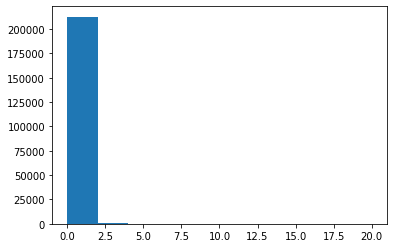

In [34]:
plt.hist(y_pred_test)

Feature Importance

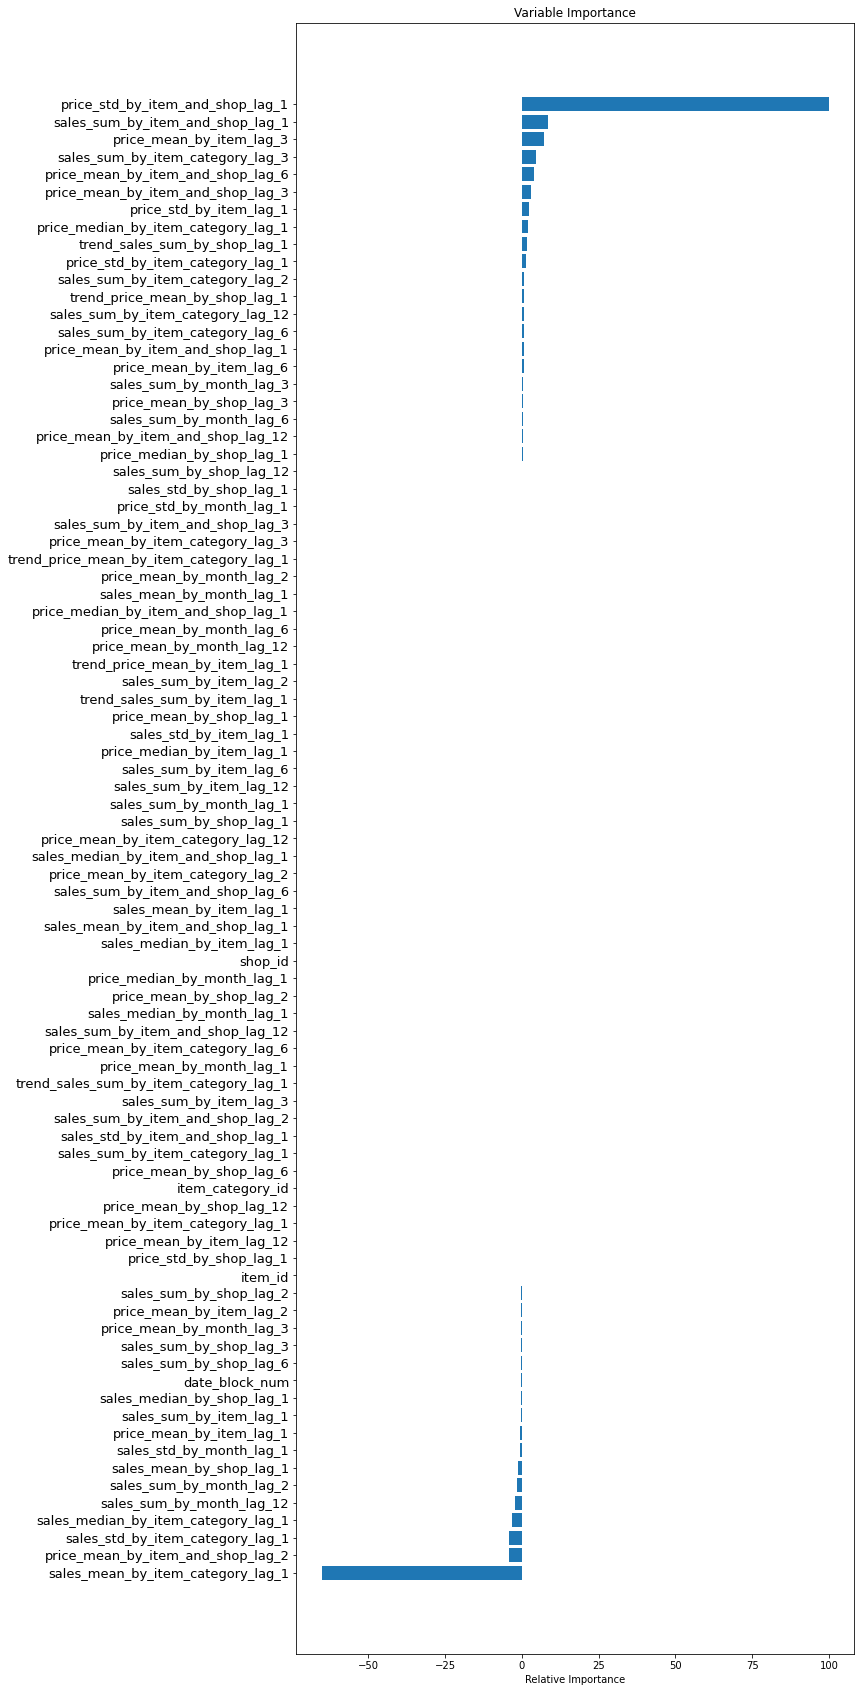

In [35]:
feature_importance = model.coef_
# summarize feature importance
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,30)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
#plt.savefig('LinReg_feature_importance.png')

Submission Prep

In [ ]:
#Folder to save models and predictions
import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

In [ ]:
import pickle
model_name = 'LinRegv4'


submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))
 
'''
# load the model from disk
loaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))
print(result)
'''

"\n# load the model from disk\nloaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))\nprint(result)\n"

In [ ]:
submission.head()

,ID,item_cnt_month
0,0,0.620781
1,1,0.429811
2,2,0.416615
3,3,0.469035
4,4,0.434907


In [36]:
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import sklearn
import time 

     |████████████████████████████████| 66.2MB 60kB/s 


LightGBM

R^2 train_score is 0.4780103795712396 R^2 val_score is 0.40238207608498533
RMSE train_score is 0.870077598920898 RMSE val_score is 0.8313940043257775
52.56191849708557


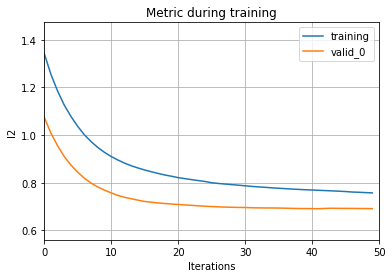

In [37]:
model_name = 'LGBM_submission_model'
X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np #X_train_np, X_val_np, X_test_np
y_train_model = y_train

#merge train and val set
#X_train_model = np.concatenate((X_train_np, X_val_np), axis=0)
#y_train_model = np.concatenate((y_train, y_val), axis=0)

#subsample
#sampling_perc = 1 #percentage to sample out of total population of data points. 10**-4 takes 18 secs
#random_indices = np.random.choice(len(X_train_model), int(len(X_train_model)*sampling_perc), replace = False)
#X_train_model, y_train_model = X_train_model[random_indices], y_train[random_indices]


start = time.time()
if load_model == True:
  model = pickle.load(open(model_name + '.sav', 'rb'))
else:
  model = LGBMRegressor(n_estimators=50, max_depth = 8)
  model.fit(X_train_model, y_train_model, eval_set=[(X_val_model, y_val), (X_train_model, y_train_model)], verbose=0)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train_model, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_score, val_score = sklearn.metrics.r2_score(y_train_model, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train_model, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))
print(time.time()-start)

lgb.plot_metric(model)

test:0.2566561497370148
val:0.2437340597182201


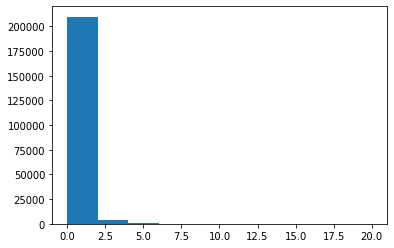

In [ ]:
plt.hist(y_pred_test)
print('test:' + str(np.mean(y_pred_test)))
print('val:' + str(np.mean(y_pred_val)))
#y_pred_test mean for: v4 filtered + v5 = 0.45, for v4 filtered features = 0.73, v4 unfiltered features after read = 0.33, v4 + v5 = 0.24, v5 = 0.27, v4 after re-creating = 0.26

In [ ]:
#Folder to save models and predictions
model_name = 'LGBM_submission_model'

import os
from google.colab import drive
drive.mount('/content/drive')
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


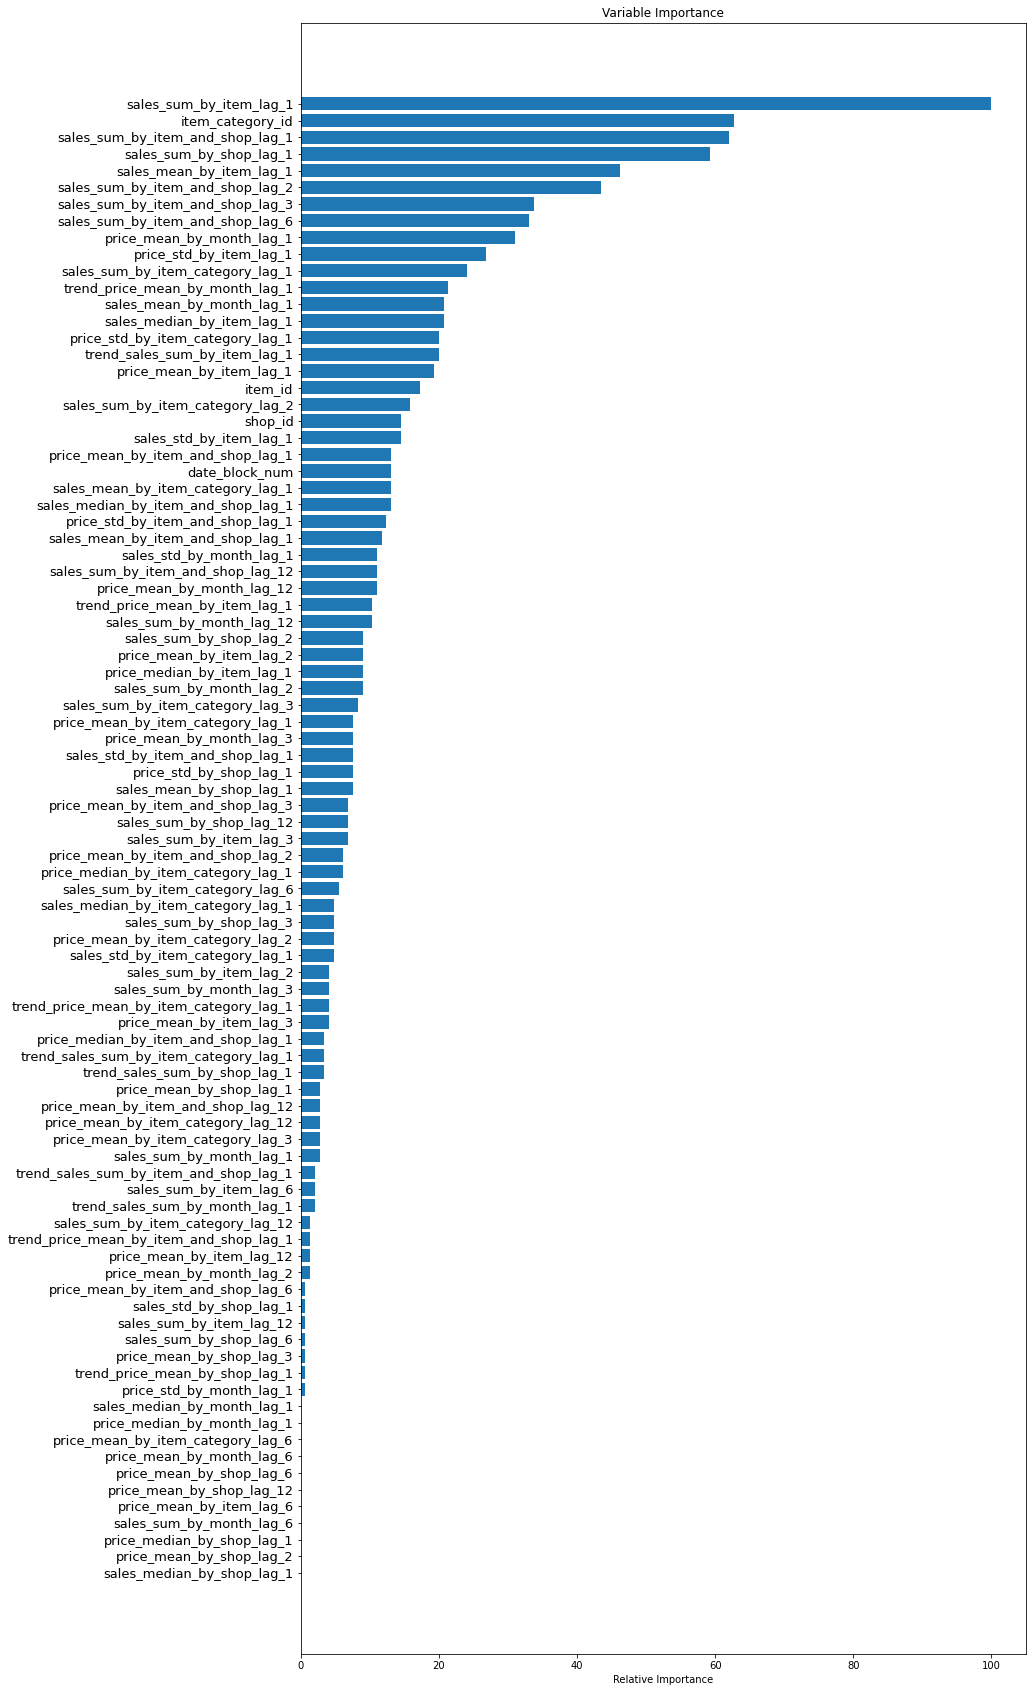

In [38]:
import matplotlib.pyplot as plt
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(13,30)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
#plt.savefig('gbt_feature_importance.png')

Submission prep

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
'''

In [ ]:
submission.head()

#Extra: Feature Importance further Analysis

In [ ]:
!pip install boruta
from boruta import BorutaPy
import numpy as np

     |████████████████████████████████| 61kB 2.8MB/s 


In [ ]:
from boruta import BorutaPy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
pd.options.display.max_rows = 100

start = time.time()
#ToDo: Can DOWNCAST to do more

#randomly sample data point - otherwise takes too long
sampling_perc = 0.03 #percentage to sample out of total population of data points. 10**-4 takes 18 secs
random_indices = np.random.choice(len(X_train), int(len(X_train)*sampling_perc), replace = False) #sample randomly without replacement

# Model for Boruta 
model_boruta = XGBRegressor(objective = 'reg:squarederror', n_estimators=15, seed=1) #For some reason LGBMRegressor and HistGradientBoostingRegressor don't seem to be compatible with Boruta. XGBRegressor, GradientBoostingRegressor, and RandomForestRegressor work (faster is XGBRegressor)
 
# Perform Boruta
boruta = BorutaPy(model_boruta, n_estimators='auto', verbose=2, max_iter = 40)
boruta.fit(X_train.values[random_indices], y_train.ravel()[random_indices])
end = time.time()

#Prepare results format
support_index = np.argwhere(boruta.support_==True)
support_weak_index = np.argwhere(boruta.support_weak_==True)
all_features_outcome = np.zeros(len(boruta.support_)).astype(object)
all_features_outcome[support_index] = 'Confirmed'
all_features_outcome[support_weak_index] = 'Tentative'
reject_index = np.argwhere(all_features_outcome == 0)
all_features_outcome[reject_index] = 'Rejected'
feature_ranking = pd.DataFrame({'feature': X_train.columns, 'rank': boruta.ranking_, 'outcome': all_features_outcome}).sort_values('rank')


# Feature selection
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = list(X_train.columns[reject_index].flatten())

print('features in the green area (confirmed):', green_area)
print('features in the blue area (tentative):', blue_area)
print('features in the red area (reject):', red_area)
print('time taken is'  + str(start - end))
feature_ranking


Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	0
Tentative: 	14
Rejected: 	86
Iteration: 	9 / 40
Confirmed: 	2
Tentative: 	12
Rejected: 	86
Iteration: 	10 / 40
Confirmed: 	2
Tentative: 	12
Rejected: 	86
Iteration: 	11 / 40
Confirmed: 	2
Tentative: 	12
Rejected: 	86
Iteration: 	12 / 40
Confirmed: 	3
Tentative: 	9
Rejected: 	88
Iteration: 	13 / 40
Confirmed: 	3
Tentative: 	9
Rejected: 	88
Iteration: 	14 / 40
Confirmed: 	3
Tentative: 	9
Rejected: 	88
Iteration: 	15 / 40
Confirmed: 	3
Tentative: 	9
Rejected: 	88
Iteration: 	16 / 40
Confirmed: 	4
Tentative: 	8
Rejected: 	88
Iterat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,feature,rank,outcome
51,sales_sum_by_item_and_shop_lag_3,1,Confirmed
50,sales_sum_by_item_and_shop_lag_1,1,Confirmed
63,sales_sum_by_month_lag_12,1,Confirmed
54,sales_sum_by_item_and_shop_lag_2,1,Confirmed
98,trend_price_mean_by_month_lag_1,2,Tentative
4,item_category_id,3,Rejected
30,sales_sum_by_shop_lag_1,4,Rejected
41,sales_sum_by_item_category_lag_3,5,Rejected
57,price_mean_by_month_lag_6,6,Rejected
92,trend_price_mean_by_shop_lag_1,7,Rejected


In [ ]:

'''
Output with 1% and 75 iterations (max =100):
features in the green area (confirmed): 
'''
a = ['sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_median_by_item_lag_1', 'sales_mean_by_item_and_shop_lag_1']
'''
features in the blue area (tentative): []
time: 15mins

Output with 3% and 50 iterations:

features in the green area (confirmed):
'''
b =  ['item_category_id', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'price_mean_by_month_lag_12', 'trend_sales_sum_by_month_lag_1']
#features in the blue area (tentative): 
#c= ['sales_sum_by_shop_lag_1', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'sales_median_by_item_lag_1', 'sales_median_by_item_and_shop_lag_1', 'trend_sales_sum_by_shop_lag_1']
'''
time: 70mins

Output with 3% and 50 iterations:
features in the green area (confirmed): 
'''
d = ['sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_median_by_item_lag_1']
#features in the blue area (tentative): 
e= ['price_median_by_item_lag_1', 'price_median_by_item_and_shop_lag_1', 'trend_price_mean_by_month_lag_1']
'''
time: 57mins

Output with 3% and 50 iterations:
features in the green area (confirmed): 
'''
f =['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'price_median_by_item_lag_1']
#features in the blue area (tentative): 
#g =['price_mean_by_item_lag_2', 'sales_sum_by_shop_lag_1', 'price_mean_by_item_and_shop_lag_1', 'price_mean_by_month_lag_6', 'sales_mean_by_month_lag_1', 'trend_price_mean_by_month_lag_1']
'''
Output with 15% and 40 iterations
features in the green area (confirmed): 24 
'''
h = ['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'price_mean_by_item_lag_2', 'sales_sum_by_item_lag_1', 'sales_sum_by_shop_lag_1', 'sales_sum_by_item_category_lag_1', 'sales_sum_by_item_category_lag_3', 'sales_sum_by_item_category_lag_2', 'price_mean_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_sum_by_month_lag_3', 'sales_sum_by_month_lag_12', 'sales_sum_by_month_lag_2', 'price_median_by_item_lag_1', 'sales_median_by_item_lag_1', 'sales_std_by_month_lag_1', 'trend_sales_sum_by_item_lag_1', 'trend_price_mean_by_month_lag_1', 'trend_sales_sum_by_month_lag_1']
#features in the blue area (tentative): 2 
#i= ['sales_sum_by_item_category_lag_6', 'price_std_by_item_category_lag_1']
'''
Outputs with 3% and 50 iterations
features in the green area (confirmed): 
'''
j = ['item_category_id', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_6', 'sales_median_by_item_lag_1']
#features in the blue area (tentative): 
#k = ['item_tested', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'price_mean_by_month_lag_12', 'sales_sum_by_month_lag_3', 'price_std_by_item_category_lag_1']
'''
Output with 3% and 40 iterations
features in the green area (confirmed): 
'''
l = ['sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12']
#features in the blue area (tentative): 
#m= ['trend_price_mean_by_month_lag_1']

#To do: run 1-2 more times with ranom samples to get more represenative of data (by considering outputs of all different data - i.e. their union)



In [ ]:

'''
Output with 1% and 75 iterations (max =100):
features in the green area (confirmed): 
'''
a = ['sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_median_by_item_lag_1', 'sales_mean_by_item_and_shop_lag_1']
'''
features in the blue area (tentative): []
time: 15mins

Output with 3% and 50 iterations:

features in the green area (confirmed):
'''
b =  ['item_category_id', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'price_mean_by_month_lag_12', 'trend_sales_sum_by_month_lag_1']
#features in the blue area (tentative): 
#c= ['sales_sum_by_shop_lag_1', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'sales_median_by_item_lag_1', 'sales_median_by_item_and_shop_lag_1', 'trend_sales_sum_by_shop_lag_1']
'''
time: 70mins

Output with 3% and 50 iterations:
features in the green area (confirmed): 
'''
d = ['sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_median_by_item_lag_1']
#features in the blue area (tentative): 
e= ['price_median_by_item_lag_1', 'price_median_by_item_and_shop_lag_1', 'trend_price_mean_by_month_lag_1']
'''
time: 57mins

Output with 3% and 50 iterations:
features in the green area (confirmed): 
'''
f =['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'price_median_by_item_lag_1']
#features in the blue area (tentative): 
#g =['price_mean_by_item_lag_2', 'sales_sum_by_shop_lag_1', 'price_mean_by_item_and_shop_lag_1', 'price_mean_by_month_lag_6', 'sales_mean_by_month_lag_1', 'trend_price_mean_by_month_lag_1']
'''
Output with 15% and 40 iterations
features in the green area (confirmed): 24 
'''
h = ['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'price_mean_by_item_lag_2', 'sales_sum_by_item_lag_1', 'sales_sum_by_shop_lag_1', 'sales_sum_by_item_category_lag_1', 'sales_sum_by_item_category_lag_3', 'sales_sum_by_item_category_lag_2', 'price_mean_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_sum_by_month_lag_3', 'sales_sum_by_month_lag_12', 'sales_sum_by_month_lag_2', 'price_median_by_item_lag_1', 'sales_median_by_item_lag_1', 'sales_std_by_month_lag_1', 'trend_sales_sum_by_item_lag_1', 'trend_price_mean_by_month_lag_1', 'trend_sales_sum_by_month_lag_1']
#features in the blue area (tentative): 2 
#i= ['sales_sum_by_item_category_lag_6', 'price_std_by_item_category_lag_1']
'''
Outputs with 3% and 50 iterations
features in the green area (confirmed): 
'''
j = ['item_category_id', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_6', 'sales_median_by_item_lag_1']
#features in the blue area (tentative): 
#k = ['item_tested', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'price_mean_by_month_lag_12', 'sales_sum_by_month_lag_3', 'price_std_by_item_category_lag_1']
'''
Output with 3% and 40 iterations
features in the green area (confirmed): 
'''
l = ['sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12']
#features in the blue area (tentative): 
#m= ['trend_price_mean_by_month_lag_1']

def CountFrequency(my_list): 
      
    # Creating an empty dictionary  
    freq = {} 
    for items in my_list: 
        freq[items] = my_list.count(items) 
    return freq
'''
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 
'''
import pandas as pd
list_union = a+b+d+f+h+j+l

item_count = CountFrequency(list_union)
features, counts = [],[]
for key, value in item_count.items():
  features.append(key)
  counts.append(value)

df= pd.DataFrame({'features':features, 'counts': counts}).sort_values('counts', ascending=False)
boruta_important_features = features
df

,features,counts
0,sales_sum_by_item_and_shop_lag_1,7
3,sales_sum_by_item_and_shop_lag_2,6
1,sales_sum_by_item_and_shop_lag_3,6
4,sales_median_by_item_lag_1,4
6,item_category_id,4
7,sales_sum_by_item_lag_1,4
2,sales_sum_by_item_and_shop_lag_6,3
8,price_mean_by_month_lag_12,3
12,sales_sum_by_month_lag_12,3
11,price_mean_by_item_lag_1,2


In [ ]:
boruta_important_features

['sales_sum_by_item_and_shop_lag_1',
 'sales_sum_by_item_and_shop_lag_3',
 'sales_sum_by_item_and_shop_lag_6',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_median_by_item_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'item_category_id',
 'sales_sum_by_item_lag_1',
 'price_mean_by_month_lag_12',
 'trend_sales_sum_by_month_lag_1',
 'item_tested',
 'price_mean_by_item_lag_1',
 'sales_sum_by_month_lag_12',
 'price_median_by_item_lag_1',
 'price_mean_by_item_lag_2',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_category_lag_1',
 'sales_sum_by_item_category_lag_3',
 'sales_sum_by_item_category_lag_2',
 'price_mean_by_item_and_shop_lag_1',
 'sales_sum_by_month_lag_3',
 'sales_sum_by_month_lag_2',
 'sales_std_by_month_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'price_mean_by_month_lag_6']

In [ ]:
xgb_important_features = list(feature_names[sorted_idx][-25:])
xgb_important_features

'''
Top 25 XGB important features (by 'Gain') (reverse order, the bottom down in the list are the most important)
xgb_gain_importance = ['price_median_by_item_category_lag_1',
 'shop_city',
 'sales_median_by_item_and_shop_lag_1',
 'price_std_by_item_and_shop_lag_1',
 'price_std_by_item_lag_1',
 'price_mean_by_month_lag_6',
 'price_std_by_item_category_lag_1',
 'sales_median_by_item_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'price_median_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_12',
 'sales_sum_by_item_category_lag_1',
 'sales_mean_by_month_lag_1',
 'sales_sum_by_item_and_shop_lag_6',
 'price_mean_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'sales_mean_by_item_lag_1',
 'item_tested',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_and_shop_lag_3',
 'item_category_id',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_sum_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_1']

 Top XGB feature importance by 'Count'
 xgb_count_importance=['price_median_by_item_lag_1',
 'sales_sum_by_item_category_lag_3',
 'sales_sum_by_month_lag_2',
 'sales_sum_by_item_and_shop_lag_12',
 'price_std_by_item_and_shop_lag_1',
 'date_block_num',
 'price_mean_by_item_and_shop_lag_1',
 'item_id',
 'price_std_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'price_std_by_item_category_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'sales_sum_by_item_category_lag_1',
 'sales_mean_by_month_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'item_category_id',
 'item_tested',
 'sales_sum_by_item_category_lag_2',
 'sales_mean_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_6',
 'sales_sum_by_item_and_shop_lag_3',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_1']
 '''

NameError: ignored

In [ ]:
#XGB count vs xgb gain feature importance - agree on 19 out of 25 features
len(set(xgb_count_importance + xgb_gain_importance))

31

In [ ]:
list(feature_importance[sorted_idx][-25:])

['price_median_by_item_lag_1',
 'sales_sum_by_item_category_lag_3',
 'sales_sum_by_month_lag_2',
 'sales_sum_by_item_and_shop_lag_12',
 'price_std_by_item_and_shop_lag_1',
 'date_block_num',
 'price_mean_by_item_and_shop_lag_1',
 'item_id',
 'price_std_by_item_lag_1',
 'trend_price_mean_by_month_lag_1',
 'price_std_by_item_category_lag_1',
 'trend_sales_sum_by_item_lag_1',
 'sales_sum_by_item_category_lag_1',
 'sales_mean_by_month_lag_1',
 'sales_mean_by_item_and_shop_lag_1',
 'item_category_id',
 'item_tested',
 'sales_sum_by_item_category_lag_2',
 'sales_mean_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_6',
 'sales_sum_by_item_and_shop_lag_3',
 'sales_sum_by_item_and_shop_lag_2',
 'sales_sum_by_shop_lag_1',
 'sales_sum_by_item_lag_1',
 'sales_sum_by_item_and_shop_lag_1']

In [ ]:
#Boruta and XGB agree in 15 out of 25 features
len(set(xgb_important_features + boruta_important_features))

34

In [ ]:
list_union.count('sales_sum_by_item_and_shop_lag_1')

7

In [ ]:
import numpy as np
#a is confirmed features from boruta until 3% and 50 iterations starting with item_category_id (after 15% with 40 iterations)
a = ['sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_median_by_item_lag_1', 'sales_mean_by_item_and_shop_lag_1'] + ['item_category_id', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'price_mean_by_month_lag_12', 'trend_sales_sum_by_month_lag_1'] + ['sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_median_by_item_lag_1'] + ['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'price_median_by_item_lag_1'] +['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'price_mean_by_item_lag_2', 'sales_sum_by_item_lag_1', 'sales_sum_by_shop_lag_1', 'sales_sum_by_item_category_lag_1', 'sales_sum_by_item_category_lag_3', 'sales_sum_by_item_category_lag_2', 'price_mean_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_sum_by_month_lag_3', 'sales_sum_by_month_lag_12', 'sales_sum_by_month_lag_2', 'price_median_by_item_lag_1', 'sales_median_by_item_lag_1', 'sales_std_by_month_lag_1', 'trend_sales_sum_by_item_lag_1', 'trend_price_mean_by_month_lag_1', 'trend_sales_sum_by_month_lag_1'] +['item_category_id', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_6', 'sales_median_by_item_lag_1']
a = np.array(a)
a_unique = np.unique(a)
len(a_unique)

26

Feature importance by time lag

In [ ]:
pd_importance = pd.DataFrame({'importances': feature_importance[sorted_idx], 'names': feature_names[sorted_idx]})
df = pd_importance 
for i in range(len(TS_features)):
  if i == 0:
    df_mrg = df[df['names'].str.contains(TS_features[i])]
  else:
    df_2 = df[df['names'].str.contains(TS_features[i])]
    df_mrg = pd.concat([df_mrg, df_2], axis = 0)

df_mrg = df_mrg[~df_mrg.names.str.contains("trend")]
df_mrg['lags'] = df_mrg['names'].str.strip().str[-2:]
df_mrg['lags'] = df_mrg['names'].str.strip().str[-2:]
df_mrg['lags'] = df_mrg['lags'].str.replace(r'_', '')

,importances,names,lags
11,23.529412,price_mean_by_item_lag_1,1
12,8.403361,price_mean_by_item_lag_3,3
13,0.000000,price_mean_by_item_lag_6,6
14,1.260504,price_mean_by_item_lag_12,12
15,11.344538,price_mean_by_item_lag_2,2
...,...,...,...
56,0.000000,sales_sum_by_month_lag_1,1
57,0.000000,sales_sum_by_month_lag_3,3
58,0.000000,sales_sum_by_month_lag_6,6
59,0.000000,sales_sum_by_month_lag_12,12


In [ ]:
#Feature Importance per lag
df_mrg.groupby(['lags']).mean().sort_values('importances', ascending=False)

,importances
lags,
1,32.112845
2,9.873950
3,8.673469
6,5.612245
12,4.051621


Feature importance by stats


> Time series features



In [ ]:
#Stats of TS features (lags of 1,3,6, 12)
df_mrg['TS_stats'] = df_mrg['names'].apply(lambda st: st[st.find("_")+1:st.find("_by")])
df_mrg.groupby(['stats']).mean().sort_values('importances', ascending=False)

,importances
stats,
sum,17.515006
mean,6.614646




> Stats based features (just lag 1)



In [ ]:
#Stats of Stats features (lag of 1)
#NOTE: Note that mean here appears in only half as much variables as std and median in Stats based features
df = pd_importance 
for i in range(len(Stats_features)):
  if i == 0:
    df_mrg_stats = df[df['names'].str.contains(Stats_features[i])]
  else:
    df_2 = df[df['names'].str.contains(Stats_features[i])]
    df_mrg_stats = pd.concat([df_mrg_stats, df_2], axis = 0)
df_mrg_stats['stats'] = df_mrg_stats['names'].apply(lambda st: st[st.find("_")+1:st.find("_by")])
df_mrg_stats.groupby(['stats']).mean().sort_values('importances', ascending=False)

,importances
stats,
mean,21.668667
std,13.925570
median,4.981993


Feature importance by "groupbys"

In [ ]:
df_mrg_stats['groupby'] = df_mrg_stats['names'].apply(lambda st: st[st.find("by_")+3:st.find("_lag")])
df_mrg_stats.groupby(['groupby']).mean().sort_values('importances', ascending=False)

,importances
groupby,
item,26.050420
item_category,12.857143
item_and_shop,10.168067
month,7.142857
shop,4.033613


Feature importance by sales-based features vs price-based features

In [ ]:
df = pd_importance 
iterable = ['price', 'sales']
for i in range(len(iterable)):
  if i == 0:
    df_mrg_2 = df[df['names'].str.startswith(iterable[i])]
  else:
    df_2 = df[df['names'].str.startswith(iterable[i])]
    df_mrg_2 = pd.concat([df_mrg_2, df_2], axis = 0)

df_mrg_2["sales_or_price"]= df["names"].str.slice(0, 5, 1) 

,importances,names,sales_or_price
11,23.529412,price_mean_by_item_lag_1,price
12,8.403361,price_mean_by_item_lag_3,price
13,0.000000,price_mean_by_item_lag_6,price
14,1.260504,price_mean_by_item_lag_12,price
15,11.344538,price_mean_by_item_lag_2,price
...,...,...,...
79,8.823529,sales_median_by_item_and_shop_lag_1,sales
80,14.705882,sales_mean_by_item_and_shop_lag_1,sales
83,10.084034,sales_std_by_month_lag_1,sales
84,0.000000,sales_median_by_month_lag_1,sales


In [ ]:
df_mrg_2.groupby(['sales_or_price']).mean().sort_values('importances', ascending=False)

,importances
sales_or_price,
sales,15.451681
price,7.515006


Mean feature importance of trended features

In [ ]:
df_trend = df[df['names'].str.contains("trend")]
df_trend.mean()

importances    8.697479
dtype: float64

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv('LGBM_v4_filtered_&_v5' + '_submission.csv', index=False)


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

Submission prep

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
'''

"\nloaded_model = pickle.load(open(model_file_name, 'rb'))\n"

# Extra: Notes

**Data Cleaning**

In [ ]:
#impute any potential missing values or deal with outliers

Feature Engineering

In [ ]:
# To construct month, year feature from data
# count of days in a month
# time components of item_price and item_cnt (value at t-1, t-2, t-3, t-6, t-12 maybe)
# rate of change of item_cnt (between t-1 and t-2 e.g.), 
# statistics on item_price and item_cnt - mean, std, range, mode, skew?


In [ ]:
#Create a distinct day, month, year column
'''
df['date'] = pd.to_datetime(df['date'], format = "%d.%m.%Y")
df['year'], df['month'], features['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
df.head()
'''
#also get day count (days in a month)

In [ ]:
model_name = 'catBoostv4'

# Prepare Categorical Variables
'''
categorical = []
for feature_engineered in features_engineered:
  categorical.append('above_12m_avg' + feature_engineered)

categorical.extend(['date_block_num','shop_id', 'item_id'])

def column_index(df, query_cols):
    indices = []
    for query_col in query_cols:
      index=df.columns.get_loc(query_col)
      indices.append(index)
    return indices
categorical_features_pos = column_index(X_train,categorical)
'''